# Cluster similar regions on a hexgrid

In [3]:
import geopandas as gpd
import pandas as pd
import scipy.stats as stats
import shapely
import seaborn as sns
import numpy as np
import libpysal
import spopt
import h3
import matplotlib.pyplot as plt
from libpysal import graph
from scipy.spatial import distance
from clustergram import Clustergram
from bokeh.io import output_notebook
from bokeh.plotting import show
from sklearn import cluster
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate

import preprocess_data

Retrieve building dataset and levels of clusters

In [4]:
buildings, levels = preprocess_data.get_buildings("/data/uscuni-ulce/boundaries_of_change/classification/")

Show area of interest (Central Europe sans Hungary)

<Axes: >

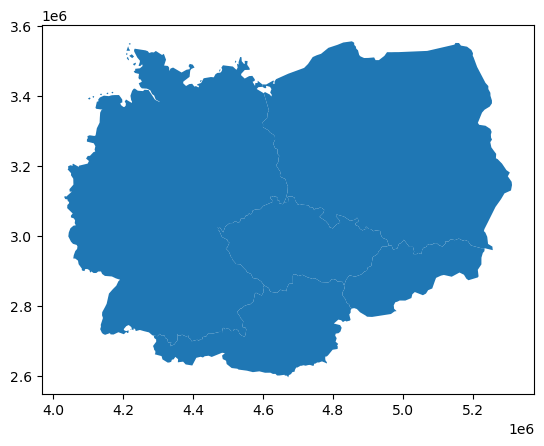

In [5]:
aoi = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1994_political")
aoi.plot()

Hexify AOI

In [6]:
hexed = h3fy(aoi, resolution=3)

/home/danka/work/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Text(0.5, 1.0, 'aoi_hexed')

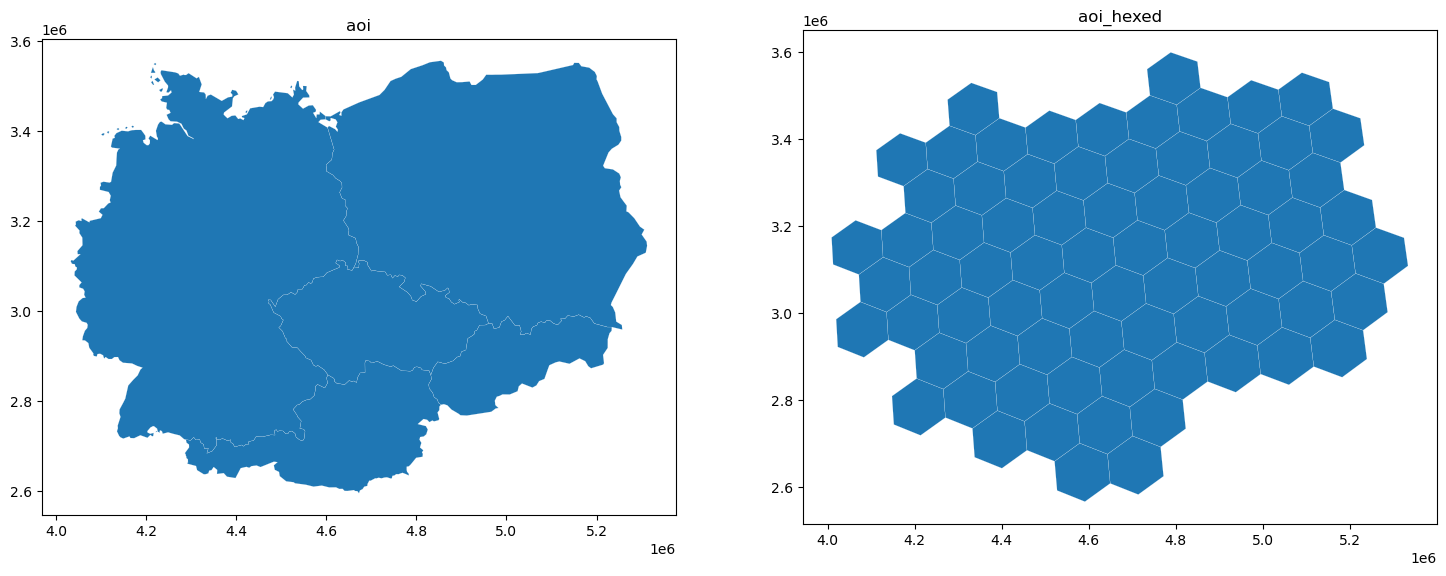

In [7]:
fig, axs = plt.subplots(1,2, figsize=(18,10))
axs=axs.flatten()

aoi.plot(ax=axs[0], linewidth=0.1, edgecolor='white')
hexed.plot(ax=axs[1], linewidth=0.1, edgecolor='white')

axs[0].set_title('aoi')
axs[1].set_title('aoi_hexed')

In [8]:
hexed

,geometry
hex_id,
831f52fffffffff,"POLYGON ((4948900.827 3247639.141, 5012283.856..."
831fabfffffffff,"POLYGON ((4322580.144 2865573.857, 4384564.554..."
831f88fffffffff,"POLYGON ((4400275.867 2642932.21, 4457929.792 ..."
831e2afffffffff,"POLYGON ((5108691.228 2942641.52, 5165268.677 ..."
831f55fffffffff,"POLYGON ((5152245.191 3530387.501, 5089637.06 ..."
...,...
831f8cfffffffff,"POLYGON ((4270425.806 2759403.495, 4332499.017..."
831f13fffffffff,"POLYGON ((4238285.619 3207119.268, 4242747.672..."
831e31fffffffff,"POLYGON ((4801848.552 2932456.398, 4794938.941..."


In [9]:
hexed.index.name = "NAME"

Join buildings dataset with the hexgrid on a specified hierarchy level

In [13]:
# def join_buildings_with_grid(level):
#     joined = gpd.sjoin(buildings, hexed, how="left", predicate="within")
#     data = joined.groupby("NAME")[level].value_counts().unstack().fillna(0)
#     data_norm = preprocess_data.normalize_building_counts(data)

#     return data_norm.T

In [32]:
joined = gpd.sjoin(buildings, hexed, how="left", predicate="within")
data = joined.groupby("NAME")["level_4"].value_counts().unstack().fillna(0)
X = data.values / data.sum(axis=1).values[:, np.newaxis]
X

array([[3.96184493e-02, 2.14243011e-02, 9.35316635e-02, 6.71441503e-02,
        2.19354941e-01, 6.02704088e-03, 5.16291055e-01, 3.66083990e-02],
       [4.32877494e-02, 1.57001276e-02, 1.31440397e-01, 9.62096681e-02,
        1.92801135e-01, 8.97940250e-03, 4.84081320e-01, 2.75002007e-02],
       [6.91721024e-02, 3.02042864e-02, 3.75915705e-02, 2.34933697e-01,
        2.90462332e-01, 1.42756792e-02, 1.32095190e-01, 1.91265142e-01],
       [4.07147982e-02, 2.05942986e-02, 6.24566314e-02, 4.09432130e-01,
        2.64281598e-01, 2.87135683e-03, 1.68764040e-01, 3.08851474e-02],
       [4.19289092e-02, 2.64402334e-02, 4.30371578e-02, 6.15526408e-02,
        2.34411582e-01, 6.56227481e-02, 3.09083824e-01, 2.17922905e-01],
       [3.47534775e-02, 1.65762022e-02, 1.56602700e-01, 6.59102939e-02,
        2.51922438e-01, 4.22624116e-03, 4.56463634e-01, 1.35450125e-02],
       [3.66667411e-02, 1.69177323e-02, 6.69880307e-02, 4.56722236e-01,
        2.58973272e-01, 1.45164290e-02, 1.27757073e-01, 2.

In [52]:
data

level_4,1,2,3,4,5,6,7,8
NAME,,,,,,,,
831e00fffffffff,39960,21609,94338,67723,221246,6079,520742,36924
831e01fffffffff,24263,8800,73673,53926,108066,5033,271330,15414
831e04fffffffff,48251,21069,26222,163878,202612,9958,92143,133417
831e05fffffffff,48466,24515,74347,487379,314595,3418,200893,36765
831e06fffffffff,40671,25647,41746,59706,227379,63654,299811,211385
...,...,...,...,...,...,...,...,...
831faafffffffff,95739,91154,27819,61968,166519,33315,1714770,304077
831fabfffffffff,52569,64410,62201,52363,236830,25389,1019419,162483
831facfffffffff,38276,47670,19107,29073,148825,15600,1013657,164733


Build a contiguity graph and perform an example agglomerative clustering using Bray–Curtis distance

In [33]:
%%time
queen = graph.Graph.build_contiguity(hexed)
agg = cluster.AgglomerativeClustering(n_clusters=6, connectivity=queen.sparse, metric=distance.braycurtis, linkage='complete')
agg.fit(X)

CPU times: user 6.78 ms, sys: 135 μs, total: 6.91 ms
Wall time: 6.54 ms


AgglomerativeClustering(connectivity=<Compressed Sparse Row sparse array of dtype 'float64'
	with 376 stored elements and shape (75, 75)>,
                        linkage='complete',
                        metric=<function braycurtis at 0x76be1b4f1c60>,
                        n_clusters=6)

In [34]:
hexed[['geometry']].explore(agg.labels_, categorical=True, tiles="CartoDB Positron")

Try different numbers of clusters and create a clustergram

In [60]:
clusters = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
labels_dict = {}

for i, k in enumerate(clusters,start=1):
    labels_dict[i] = cluster.AgglomerativeClustering(n_clusters=k, connectivity=queen.sparse, metric=distance.braycurtis, linkage='complete').fit_predict(X)
    
labels = pd.DataFrame(labels_dict)
labels

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,1,1,3,3,3,3,3,3,3,3,3,3,3,1,1
1,0,0,0,0,1,1,1,0,0,0,4,4,4,4,4,4
2,0,0,0,0,1,1,1,0,8,8,8,8,8,8,8,8
3,0,0,0,0,1,1,1,0,0,4,10,10,10,10,10,10
4,0,1,1,3,3,3,3,3,3,3,3,3,3,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0,0,0,0,1,1,1,0,0,0,4,4,4,4,4,4
71,0,0,0,1,0,0,0,7,7,7,7,7,7,7,7,7
72,0,0,0,0,4,4,4,4,4,9,9,9,9,9,9,9
73,0,0,0,1,0,0,2,2,2,2,2,2,5,5,5,5


<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

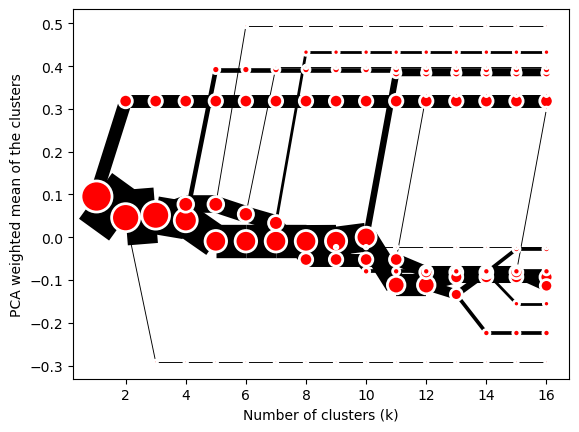

In [41]:
cgram = Clustergram.from_data(X, labels)
cgram.plot()

In [42]:
output_notebook()

Loading BokehJS ...

In [43]:
fig = cgram.bokeh()
show(fig)

Plot clusterized hexagons

In [46]:
def plot_cluster_maps(show_borders=False):
    fig, axs = plt.subplots(figsize=(15,10), nrows=4, ncols=4)
    axs = axs.flatten()
    
    for cluster, ax in zip(labels, axs):
        if show_borders:
            aoi.boundary.plot(ax=ax, color="maroon")
        hexed[["geometry"]].plot(labels[cluster].to_numpy(), ax=ax, categorical=True, cmap='tab20')
        ax.set_title(f"Number of clusters: {cluster}")
    
    plt.tight_layout()

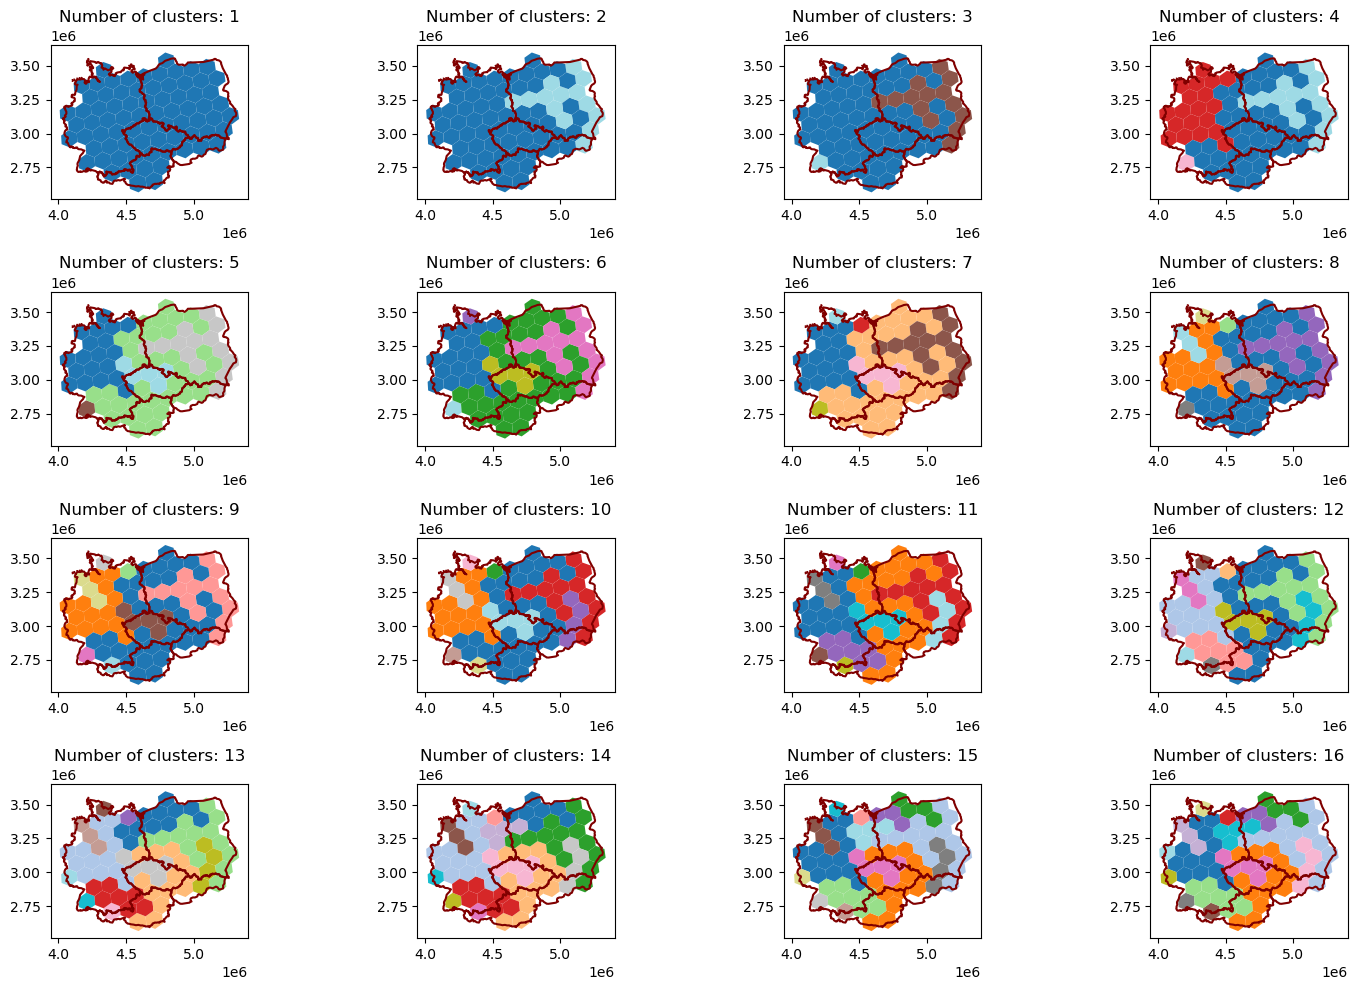

In [47]:
plot_cluster_maps(show_borders=True)

## Note to self: why are there 16 clusters again